(c) 2022 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Activate project
@load_pkg jlStatGen

# Import project package
import jlStatGen

# Import basic math
import LinearAlgebra

# Load libraries for plotting
using CairoMakie # for static plotting
using WGLMakie # for interactive plotting
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
jlStatGen.viz.pboc_makie!()

# Define output directory
output_dir = "$(git_root())/book/figures/forces_evolution";

# The Forces of Evolution

## Deterministic Forces

### Mutation

Plotting allele frequency $x(t)$ as a function of time $t$. The solution to the
differential equation is of the form
$$
x(t) = \frac{\mu_{a\rightarrow A}}
{\mu_{a\rightarrow A} + \mu_{A\rightarrow a}} 
- \frac{\left[  \mu_{a\rightarrow A} - (\mu_{a\rightarrow A} + 
\mu_{A\rightarrow a}) x_o \right] 
\mathrm{e}^{- (\mu_{a\rightarrow A} + \mu_{A\rightarrow a}) t}}
{\mu_{a\rightarrow A} + \mu_{A\rightarrow a}}.
\tag{1}
$$

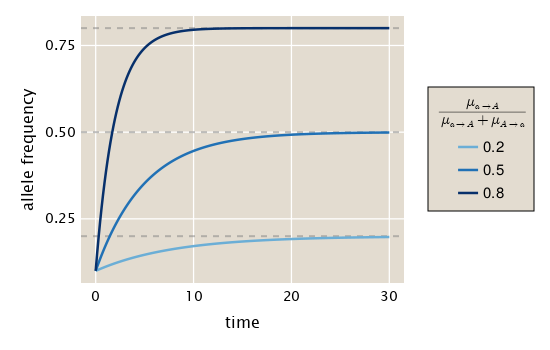

In [2]:
# Define ranges of mutations to chose
μAa = 0.1
μaA_array = [
    µAa * 0.2 / (1 - 0.2), µAa * 0.5 / (1 - 0.5), µAa * 0.8 / (1 - 0.8)
]

# Define initial frequency
xₒ  = 0.1

# Define range of time to evaluate
time = LinRange(0, 30, 200)

# Set figure resolution
figres = 350

# Inititalize figure
fig = Figure(resolution=(figres + 200, figres))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time",
    ylabel="allele frequency",
)

# Define colors
color = get(ColorSchemes.Blues_9, LinRange(0.5, 1, length(µaA_array)))

# Loop through selection coefficients
for (i, µaA) in enumerate(µaA_array)
    # Evaluate allele frequency
    x = @. µaA / (µaA + µAa) - 
    ((µaA - (µaA + µAa) * xₒ) * exp(-(µaA + µAa) * time)) / (µaA + µAa)
    
    # Plot expectd steady-state allele frequency
    hlines!(
        ax, µaA / (µaA + µAa), linestyle=:dash, color=(:gray, 0.5), linewidth=2
    )

    # Plot time vs allele frequency
    lines!(
        ax, 
        time, 
        x, 
        color=color[i], 
        linewidth=2.5, 
        label="$(round(µaA / (µaA + µAa), sigdigits=2))"
    )
end # for

Legend(
    fig[1, 2], 
    ax, 
    L"\frac{\mu_{a\rightarrow A}}{\mu_{a\rightarrow A} + \mu_{A\rightarrow a}} "
)

# Save figure as png
save("$output_dir/_mutation_dynamics.png", fig)
# Define figure size in inches
size_in_inches = 3
# Define size for pdf
size_pt = 72 * size_in_inches
# Safe figure as pdf
save(
    "$output_dir/_mutation_dynamics.pdf",
    fig,
    pt_per_unit=size_pt / figres,
)

fig

## Interactive plot

Let us now generate an interactive plot where we can manipulate the mutation
rate and see the plot change. For this, we will use the `WGLMakie` plotting end.

The first thing we must do is activate this plotting end.

In [3]:
# Activate interactive plot backend
WGLMakie.activate!()

Next, we plot the allele frequency over time. We will define three sliders, one
for $\mu_{A\rightarrow a}$, one for $\mu_{a\rightarrow A}$, and one for $x_o$.

In [4]:
# Inititalize figure
fig = Figure(resolution=(500, 600))

# Define interactive sliders for µaA, µAa, and xₒ
mut_sliders = SliderGrid(
    fig[2, 1], 
    (range = 0.01:0.01:1, startvalue=0.1, horizontal=true, label="µaA"),
    (range = 0.01:0.01:1, startvalue=0.01, horizontal=true, label="µAa"),
    (range = 0.0:0.01:1, startvalue=0.1, horizontal=true, label="xₒ")
)

# Define range of time to evaluate
time = LinRange(0, 30, 200)

# Generate an observable that uses the slider values to compute the allele
# frequency
x = lift(
    mut_sliders.sliders[1].value,
    mut_sliders.sliders[2].value, 
    mut_sliders.sliders[3].value,
    ) do µaA, µAa, xₒ
    # Compute allele frequency
    @. µaA / (µaA + µAa) - 
    ((µaA - (µaA + µAa) * xₒ) * exp(-(µaA + µAa) * time)) / (µaA + µAa)
end # do

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time",
    ylabel="allele frequency",
)

# Plot time vs allele frequency
lines!(ax, time, x, linewidth=2.5)

ylims!(ax, 0, 1)

fig